In [1]:
import pandas as pd
import urllib.request
import requests
from bs4 import BeautifulSoup
import numpy as np

import json
from geopy.geocoders import Nominatim
import requests # library to handle requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

import folium

from sklearn.cluster import KMeans

In [2]:
url=requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

In [3]:
soup=BeautifulSoup(url,'html.parser')
table=soup.find('table')

In [4]:
def wiki_table(cname,cols):
    header = [head.find_all(text=True)[0].strip() for head in table.find_all("th")]
    data   = [[td.find_all(text=True)[0].strip() for td in tr.find_all("td")]
              for tr in table.find_all("tr")]
    data    = [row for row in data if len(row) == cols]
    # Store data to this temporary dataframe
    raw_df = pd.DataFrame(data,columns=header)
    return raw_df

In [5]:
toronto_df=wiki_table("wikitable",3)
print(toronto_df.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 3 columns):
Postal Code     180 non-null object
Borough         180 non-null object
Neighborhood    180 non-null object
dtypes: object(3)
memory usage: 4.3+ KB
None


In [6]:
toronto_df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,
1,M2A,Not assigned,
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Lets drop not assigned Boroughs and convert null neighborhoods to Boroughs.

In [7]:
toronto_df = toronto_df[toronto_df.Borough != "Not assigned"].reset_index(drop=True)

for index, row in toronto_df.iterrows():
    if row['Neighborhood']=='Not Assigned':
        row['Neighborhood']==row['Borough']

toronto_df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [8]:
toronto_df.shape

(103, 3)

In [9]:
print(len(toronto_df['Postal Code'].unique()))
print(len(toronto_df['Borough'].unique()))
print(len(toronto_df['Neighborhood'].unique()))

103
10
98


So, we have total of 103 unique postal codes

### End-Part1

### Getting Latitudes and Longitudes using Geocoder

In [10]:
toronto_df.to_csv("Postal_codes_of_Toronto")

As the system is taking a lot of time, to run the given code in courseera, I am taking available geospatial codes from the past here. 

In [11]:
toronto_df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [12]:
coordinates=pd.read_csv('Geospatial_Coordinates.csv')
coordinates.columns=['Postal Code','latitude','longitude']
coordinates.head()

,Postal Code,latitude,longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [13]:
df=toronto_df.merge(coordinates, on='Postal Code', how='left')
df.head()

,Postal Code,Borough,Neighborhood,latitude,longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [14]:
df.shape

(103, 5)

In [15]:
df.isnull().sum()

Postal Code     0
Borough         0
Neighborhood    0
latitude        0
longitude       0
dtype: int64

### End-Part2

## Exploaration of Toronto

In [16]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


In [17]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['latitude'], df['longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

From the map, we can see that Downtown toronto is most dense as suggested by neughborhoods

In [18]:
df.Borough.unique()

array(['North York', 'Downtown Toronto', 'Etobicoke', 'Scarborough',
       'East York', 'York', 'East Toronto', 'West Toronto',
       'Central Toronto', 'Mississauga'], dtype=object)

## Venues by using Four Square

In [19]:
lat = df.loc[0, 'latitude'] # neighborhood latitude value
lon = df.loc[0, 'longitude'] # neighborhood longitude value

neighborhood = df.loc[0, 'Neighborhood'] # neighborhood name
print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood, lat, lon))

CLIENT_ID = 'TZSKIX4U2SULRQ0U4C1UJCQDJ1KFMUNT4UTFMV0V1HWWTZML' # your Foursquare ID
CLIENT_SECRET = 'YO3R5YBF05E2GSJ4ASIL1J3GXORBFD0BSV0CZRIDLTLTZNOT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


LIMIT = 100
radius =600
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, lat,lon, radius, LIMIT)

# gettig the venues data form Forsquare API in json format
results = requests.get(url).json()
results

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


{'meta': {'code': 200, 'requestId': '5ebb301ebe61c9001b247d20'},
 'response': {'headerLocation': 'Parkwoods - Donalda',
  'headerFullLocation': 'Parkwoods - Donalda, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 43.75865860540001,
    'lng': -79.32219458781913},
   'sw': {'lat': 43.7478585946, 'lng': -79.33711841218087}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e8d9dcdd5fbbbb6b3003c7b',
       'name': 'Brookbanks Park',
       'location': {'address': 'Toronto',
        'lat': 43.751976046055574,
        'lng': -79.33214044722958,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.751976046055574,
          'lng': -79.33214044722958}],
        'distance': 245,
        'cc': 'CA',

#### Function to get category of venue Details

In [20]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
# type your answer here

toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['latitude'],
                                   longitudes=df['longitude']
                                  )


Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview
The Danforth West, Ri

In [23]:
print(toronto_venues.shape)
toronto_venues.head()

(2120, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,GTA Restoration,43.753396,-79.333477,Fireworks Store
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [24]:
toronto_venues['Venue Category'].value_counts()

Coffee Shop         177
Café                100
Restaurant           70
Park                 48
Pizza Place          48
                   ... 
School                1
Hardware Store        1
Drugstore             1
Harbor / Marina       1
Stationery Store      1
Name: Venue Category, Length: 270, dtype: int64

There are total of 2120 venues as given by four square, of whihc coffee shop has taken the first two places by 277 venues

In [25]:
toronto_venues.groupby('Neighborhood')['Venue'].count().sort_values(ascending=False)

Neighborhood
Toronto Dominion Centre, Design Exchange                                  100
Garden District, Ryerson                                                  100
Harbourfront East, Union Station, Toronto Islands                         100
First Canadian Place, Underground city                                    100
Commerce Court, Victoria Hotel                                            100
                                                                         ... 
Rouge Hill, Port Union, Highland Creek                                      2
Scarborough Village                                                         2
Humber Summit                                                               1
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale      1
York Mills, Silver Hills                                                    1
Name: Venue, Length: 94, dtype: int64

### Analyzing Each Neighborhood

In [26]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
toronto_onehot.shape

(2120, 270)

So, we have a total of 2120 venues of 270 different categories

In [28]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [29]:
toronto_grouped.shape

(94, 270)

We have total of 94 neighborhoods with 270 different categories of venues distributed in this

In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] =toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Skating Rink,Lounge,Breakfast Spot,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Fabric Shop,Donut Shop
1,"Alderwood, Long Branch",Pizza Place,Gym,Sandwich Place,Dance Studio,Athletics & Sports,Pub,Pool,Skating Rink,Pharmacy,Coffee Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Shopping Mall,Deli / Bodega,Middle Eastern Restaurant,Sushi Restaurant,Restaurant,Diner,Fried Chicken Joint,Chinese Restaurant
3,Bayview Village,Café,Bank,Chinese Restaurant,Japanese Restaurant,Women's Store,Dog Run,Diner,Discount Store,Distribution Center,Doner Restaurant
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sushi Restaurant,Restaurant,Coffee Shop,Sandwich Place,Juice Bar,Pub,Café,Indian Restaurant,Pizza Place


For examle in the neighborhoood, long Branch or Alderwood, we can see that there are dance studios, oubs, poolm gym whihc would suggest this as a sports arena 

## Clustering Using K-Means

In [32]:
import matplotlib.pyplot as plt
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(toronto_grouped_clustering).score(toronto_grouped_clustering) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

<Figure size 640x480 with 1 Axes>

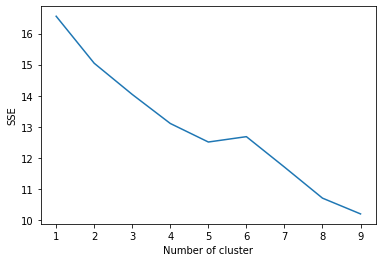

In [33]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(toronto_grouped_clustering)
    toronto_grouped_clustering["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [34]:
# set number of clusters
kclusters = 5
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 4, 1, 1, 1, 4, 1, 4, 1, 1, 1, 0, 1, 1, 1, 1, 4, 1, 1, 1, 4,
       1, 0, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 3, 1,
       1, 1, 1, 1, 4, 2])

In [35]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,4.0,Park,Fireworks Store,Food & Drink Shop,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,1.0,Grocery Store,Coffee Shop,Hockey Arena,Portuguese Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Deli / Bodega
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.0,Coffee Shop,Bakery,Park,Café,Theater,Pub,Restaurant,Breakfast Spot,Shoe Store,Farmers Market
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1.0,Women's Store,Coffee Shop,Boutique,Miscellaneous Shop,Furniture / Home Store,Arts & Crafts Store,Clothing Store,Event Space,Accessories Store,Vietnamese Restaurant
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.0,Coffee Shop,Sushi Restaurant,Distribution Center,Park,Music Venue,Mexican Restaurant,Juice Bar,Japanese Restaurant,Italian Restaurant,Hobby Shop


In [36]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['latitude'], toronto_merged['longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [37]:
toronto_merged['Cluster Labels'].value_counts(ascending=False)

1.0    84
4.0     8
0.0     5
2.0     1
3.0     1
Name: Cluster Labels, dtype: int64

We can see that most of the neighborhoods fall into cluster 1. To see wthe reason, lets explore further each of these clusters

## Exploring Clusters

#### cluster0

In [39]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Scarborough,0.0,Golf Course,Bar,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
21,York,0.0,Women's Store,Pool,Electronics Store,Bar,Park,Comic Shop,Concert Hall,Event Space,Ethiopian Restaurant,College Stadium
27,North York,0.0,Mediterranean Restaurant,Dog Run,Golf Course,Pool,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
94,Etobicoke,0.0,Bar,Rental Car Location,Drugstore,Women's Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
98,Etobicoke,0.0,Park,Smoke Shop,Pool,River,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


The cluster is defined based on the recreational places or relaxation places with venues like Bar, Golf course, Park, Pool and some restaurents

#### Cluster1

In [47]:
x=toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
x

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,1.0,Grocery Store,Coffee Shop,Hockey Arena,Portuguese Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Deli / Bodega
2,Downtown Toronto,1.0,Coffee Shop,Bakery,Park,Café,Theater,Pub,Restaurant,Breakfast Spot,Shoe Store,Farmers Market
3,North York,1.0,Women's Store,Coffee Shop,Boutique,Miscellaneous Shop,Furniture / Home Store,Arts & Crafts Store,Clothing Store,Event Space,Accessories Store,Vietnamese Restaurant
4,Downtown Toronto,1.0,Coffee Shop,Sushi Restaurant,Distribution Center,Park,Music Venue,Mexican Restaurant,Juice Bar,Japanese Restaurant,Italian Restaurant,Hobby Shop
6,Scarborough,1.0,Fast Food Restaurant,Print Shop,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...
97,Downtown Toronto,1.0,Coffee Shop,Café,Gym,Japanese Restaurant,Hotel,Restaurant,Salad Place,Steakhouse,Asian Restaurant,American Restaurant
99,Downtown Toronto,1.0,Sushi Restaurant,Coffee Shop,Japanese Restaurant,Restaurant,Yoga Studio,Mediterranean Restaurant,Hotel,Gastropub,Gay Bar,Men's Store
100,East Toronto,1.0,Yoga Studio,Auto Workshop,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Light Rail Station,Comic Shop,Pizza Place,Recording Studio
101,Etobicoke,1.0,Baseball Field,Deli / Bodega,Construction & Landscaping,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Women's Store


In [48]:
x.Borough.value_counts(ascending=False)

North York          19
Downtown Toronto    18
Scarborough         13
Etobicoke            8
Central Toronto      7
West Toronto         6
East Toronto         5
East York            4
York                 3
Mississauga          1
Name: Borough, dtype: int64

The cluster is mainly consisting of North York and Downtown tornoto, with venues like food places, shopping arenas and markets which would define most of the high density populated areas and down towns with ot of business happening.

#### cluster4

In [42]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,4.0,Park,Fireworks Store,Food & Drink Shop,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
32,Scarborough,4.0,Convenience Store,Playground,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store
35,East York,4.0,Park,Coffee Shop,Convenience Store,Ethiopian Restaurant,Event Space,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Deli / Bodega
61,Central Toronto,4.0,Park,Swim School,Bus Line,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
66,North York,4.0,Park,Bank,Convenience Store,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Department Store,Doner Restaurant
83,Central Toronto,4.0,Park,Playground,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
85,Scarborough,4.0,Park,Playground,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
91,Downtown Toronto,4.0,Park,Playground,Trail,Electronics Store,Eastern European Restaurant,Ethiopian Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dance Studio


cluster 4 is clearly defined with parks and playground as most common venues which can be found in 8 neighborhoods. <br>
1. With the parks comes the Dog Run, playground, Dim Sum Restaurents and Diners as common combination, which would tailor the neighborhoods more prone towards young people living with Animals and also old people

#### cluster2

In [43]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,North York,2.0,Cafeteria,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,Deli / Bodega


#### cluster3

In [44]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Etobicoke,3.0,Brewery,Women's Store,Department Store,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant
